### Group: Emma and Frankie
KNN Regression


Import packages and data. 

In [ ]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cartopy as cp
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
# Import data and take a very quick look at it
jmadata = pd.read_csv("./Data/jma_nitrate.csv")
# jmadata = pd.read_csv("../data/jma_nitrate.csv") # please do not change. comment out & use path above. 
jmadata.columns

Index(['Unnamed: 0', 'theta', 'sal', 'depth', 'nitrate', 'lon', 'lat', 'date',
       'year', 'month', 'day', 'profile', 'cruise', 'vessel', 'density'],
      dtype='object')

In [ ]:
# Import Argo data without nitrate

# emma's path
bgcdata = pd.read_csv('./Data/kuro_BGCargo_noNO3.csv')

# franky's path
# do not change code a below just comment out and pull back in your code.
# infile = "../data/kuro_BGCargo_noNO3_2.csv"  
# bgcdata = pd.read_csv(infile, delimiter= ',')


bgcdata['year'] = pd.DatetimeIndex(bgcdata['Date/GMT']).year
bgcdata['month'] = pd.DatetimeIndex(bgcdata['Date/GMT']).month
bgcdata.columns





Index(['Date/GMT', 'Days since 1/1/1900', 'DEPTH[M]', 'PRESSURE[DBAR]', 'NA',
       'SALINITY[PSS]', 'TEMPERATURE[C]', 'SIGMATHETA[KG/M3]',
       'OXYGEN[uMOL/KG]', 'OXYGENSAT', 'LON', 'LAT', 'year', 'month'],
      dtype='object')

In [ ]:
# Import Argo nitrate data
# emma's path
bgcno3data = pd.read_csv('./data/kuro_BGCargo_NO3.csv', delimiter=',')
# franky's path
# bgcno3data = pd.read_csv('../data/kuro_BGCargo_NO3_2.csv', delimiter=',')


bgcno3data['year'] = pd.DatetimeIndex(bgcno3data['Date/GMT']).year
bgcno3data['month'] = pd.DatetimeIndex(bgcno3data['Date/GMT']).month
bgcno3data.columns




Index(['Date/GMT', 'Days since 1/1/1900', 'NITRATE[uMOL/KG]', 'DEPTH[M]',
       'PRESSURE[DBAR]', 'NA', 'SALINITY[PSS]', 'TEMPERATURE[C]',
       'SIGMATHETA[KG/M3]', 'OXYGEN[uMOL/KG]', 'OXYGENSAT', 'LON', 'LAT',
       'year', 'month'],
      dtype='object')

In [ ]:
# Since we have a NaN value for nitrate (-999) and negative BGC nitrate values, we need to get rid of that:
jmadata = jmadata[jmadata['nitrate']>0]
bgcno3data = bgcno3data[bgcno3data['NITRATE[uMOL/KG]']>0]

## Exploratory Data Analysis ## 

Before developing the model, we assess the level of overlap between the range of environmental conditions represented in the JMA and BGC Argo data sets. The geographical extent; depth range; water masses; and the interannual and seasonal coverage of each data set could affect the performance of the model to make predictions independent of model training variablity. 

In [ ]:
jmadata.describe()

,Unnamed: 0,theta,sal,depth,nitrate,lon,lat,year,month,day,profile,density
count,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000
mean,8175.135932,7.042844,34.433404,1418.388211,26.855277,151.599624,32.696928,2012.313664,6.851034,13.509375,268.636766,26.574613
std,4675.484666,7.113994,0.354281,1528.846644,15.480812,9.692016,8.979100,1.684952,2.660677,8.723439,148.651926,1.221275
min,0.000000,0.034400,32.349200,0.000000,0.010000,133.990833,0.332167,2010.000000,2.000000,1.000000,1.000000,20.951302
25%,4105.250000,1.589650,34.240600,203.000000,11.250000,145.727833,30.003333,2011.000000,5.000000,6.000000,139.000000,25.882225
50%,8228.500000,3.418650,34.550800,803.000000,35.350000,148.149667,34.239500,2012.000000,7.000000,12.000000,275.000000,27.094050
75%,12223.750000,12.294850,34.681800,2002.000000,39.797500,164.231000,39.660833,2013.000000,9.000000,20.000000,394.000000,27.527512
max,16220.000000,29.923300,35.548100,6161.000000,45.330000,170.035167,49.991500,2016.000000,12.000000,31.000000,529.000000,27.681606


In taking a broad look at the JMA data, the basic minimums and maximums for each variable indicate that there are no other extreme outliers (or NA values in the form of extremely unrealistic numbers). The samples range from around 133º to 170º longitude, and 0º to 50º latitude, which will be explored more later. Collections occured between 2010 and 2016, with no sampling in January for any years (no month = 1), again explored more in depth later.

In [ ]:
bgcno3data.describe()

,since,NITRATE[uMOL/KG],DEPTH[M],PRESSURE[DBAR],profile,SALINITY[PSS],TEMPERATURE[C],SIGMATHETA[KG/M3],OXYGEN[uMOL/KG],OXYGENSAT,LON,LAT,year,month
count,16136.000000,16136.000000,16136.000000,16136.000000,16136.000000,16136.000000,16136.000000,16136.000000,1.613600e+04,1.613600e+04,16136.000000,16136.000000,16136.000000,16136.000000
mean,42033.532222,11.367502,-276.153707,-278.469741,6.720191,34.476596,14.046241,25.635727,inf,inf,167.317041,33.298311,2014.561292,6.720191
std,404.512161,13.206730,255.841439,258.212597,3.357582,0.267405,5.421896,0.922911,inf,inf,6.650333,1.943762,1.098196,3.357582
min,41335.568000,-6.050000,-990.493000,-999.800000,1.000000,33.675300,3.018000,21.966000,2.280000e+01,7.100000e+00,148.325000,30.092000,2013.000000,1.000000
25%,41684.360000,1.950000,-348.988500,-351.730000,4.000000,34.271800,10.776225,25.184000,1.915000e+02,7.330000e+01,163.251000,31.765000,2014.000000,4.000000
50%,42034.303000,6.570000,-200.253000,-201.765000,7.000000,34.537900,15.179800,25.601000,2.127000e+02,8.650000e+01,169.269000,32.565000,2015.000000,7.000000
75%,42382.406000,15.090000,-76.392250,-76.947500,10.000000,34.688225,17.509325,26.225000,2.281000e+02,9.770000e+01,171.610000,34.901000,2016.000000,10.000000
max,42736.536000,50.460000,-4.061000,-4.090000,12.000000,35.350200,27.426200,27.410000,1.790000e+308,1.790000e+308,176.199000,37.759000,2017.000000,12.000000


In taking a broad look at the BGC Argo data, the basic minimums and maximums for all variables indicate no extreme outliers (or NA values in the form of extremely unrealistic numbers). The Oxygen data has infinite mean and std, but that is not a variable present in the JMA data, so it will not be explored here. The samples range from about 148º to 178º longitude and 30º to 40º latitude, which will be explored more in depth next. Collections occur between 2013 and 2017, with collections happening in the full range of months (starts at January). Depth is on a different scale than JMA - it is negative, which will be fixed later.

Text(0, 0.5, 'Number of Observations per bin')

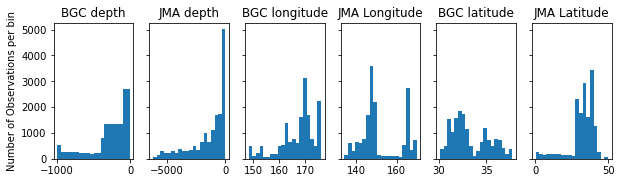

In [ ]:
n_bins = 20
fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(1, 6, figsize = (10,2.5),sharey=True)

ax1.hist(bgcdata['DEPTH[M]'], bins=n_bins)
ax2.hist(-jmadata['depth'], bins=n_bins)
ax3.hist(bgcdata['LON'], bins=n_bins)
ax4.hist(jmadata['lon'], bins=n_bins)
ax5.hist(bgcdata['LAT'], bins=n_bins)
ax6.hist(jmadata['lat'], bins=n_bins)

ax1.set_title("BGC depth")
ax2.set_title("JMA depth")
ax3.set_title("BGC longitude")
ax4.set_title("JMA Longitude")
ax5.set_title("BGC latitude")
ax6.set_title("JMA Latitude")

ax1.set_ylabel('Number of Observations per bin')



The spatial distributions of these two data sets are reasonably complementary. They same bias to surface measurements, however, JMA does go to much deeper depths than the BGC data. The JMA data set has a much larger geographical range in latitude and longitude, however has the greatest density in proxmity to BGC ranges. 

Text(0, 0.5, 'Number of Observations per year')

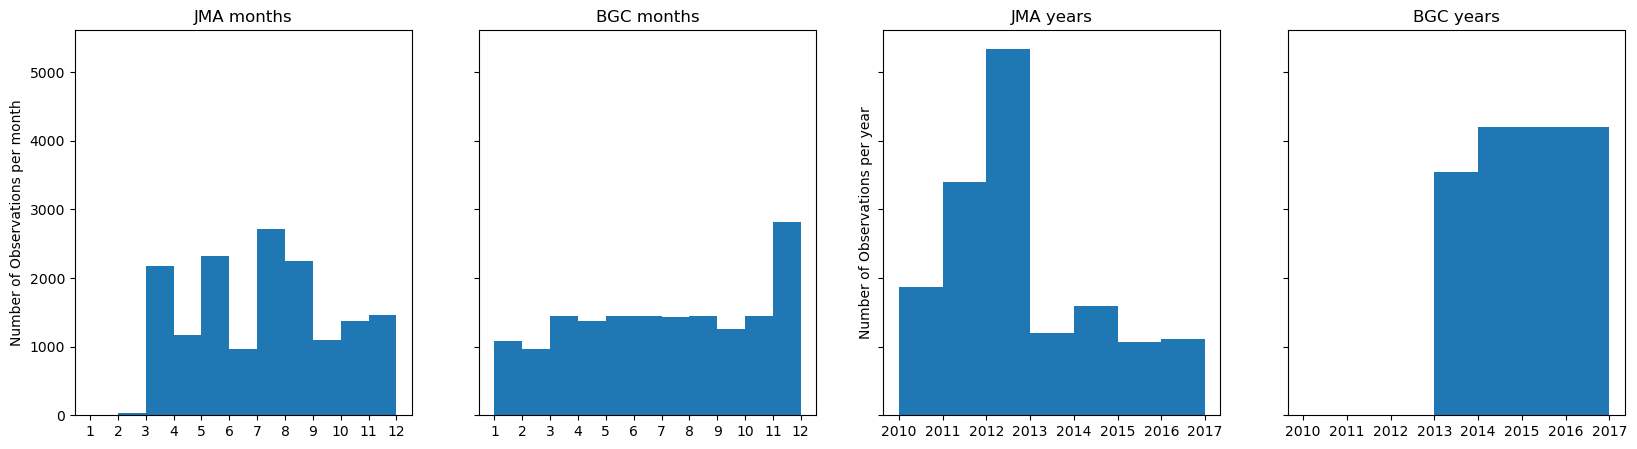

In [ ]:
fig,[ax1,ax2,ax3,ax4] = plt.subplots(1,4, figsize = (20,5),sharey=True)

month_bins = range(1,13,1)
ax1.hist(jmadata['month'], month_bins)
ax2.hist(bgcdata['month'], month_bins)

ax1.set_xticks(np.arange(1, 13, 1))
ax2.set_xticks(np.arange(1, 13, 1))

year_bins = range(2010, 2018, 1)
ax3.hist(jmadata['year'], year_bins)
ax4.hist(bgcdata['year'],  year_bins)

ax1.set_title("JMA months")
ax2.set_title("BGC months")
ax3.set_title("JMA years")
ax4.set_title("BGC years")

ax1.set_ylabel('Number of Observations per month')
ax3.set_ylabel('Number of Observations per year')

The data sets have some overlap in terms of years, however more observations for JMA were taken in 2010-2012, where there are no BGC observations, and JMA has significantly less observations in the years that BGC data was collected (2013–2016). In terms of seasonal coverate, JMA is missing observations in January and February (a very small number in Feb), and has higher observations every other month at the beginning of the year and closer to equal coverage at the end of the year. BGC has relatively even coverage with almost double observations in December. Overall, both datasets cover all seasons and are close in times/years collected.

/Users/frank/opt/anaconda3/envs/OEAS895environment/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/frank/opt/anaconda3/envs/OEAS895environment/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


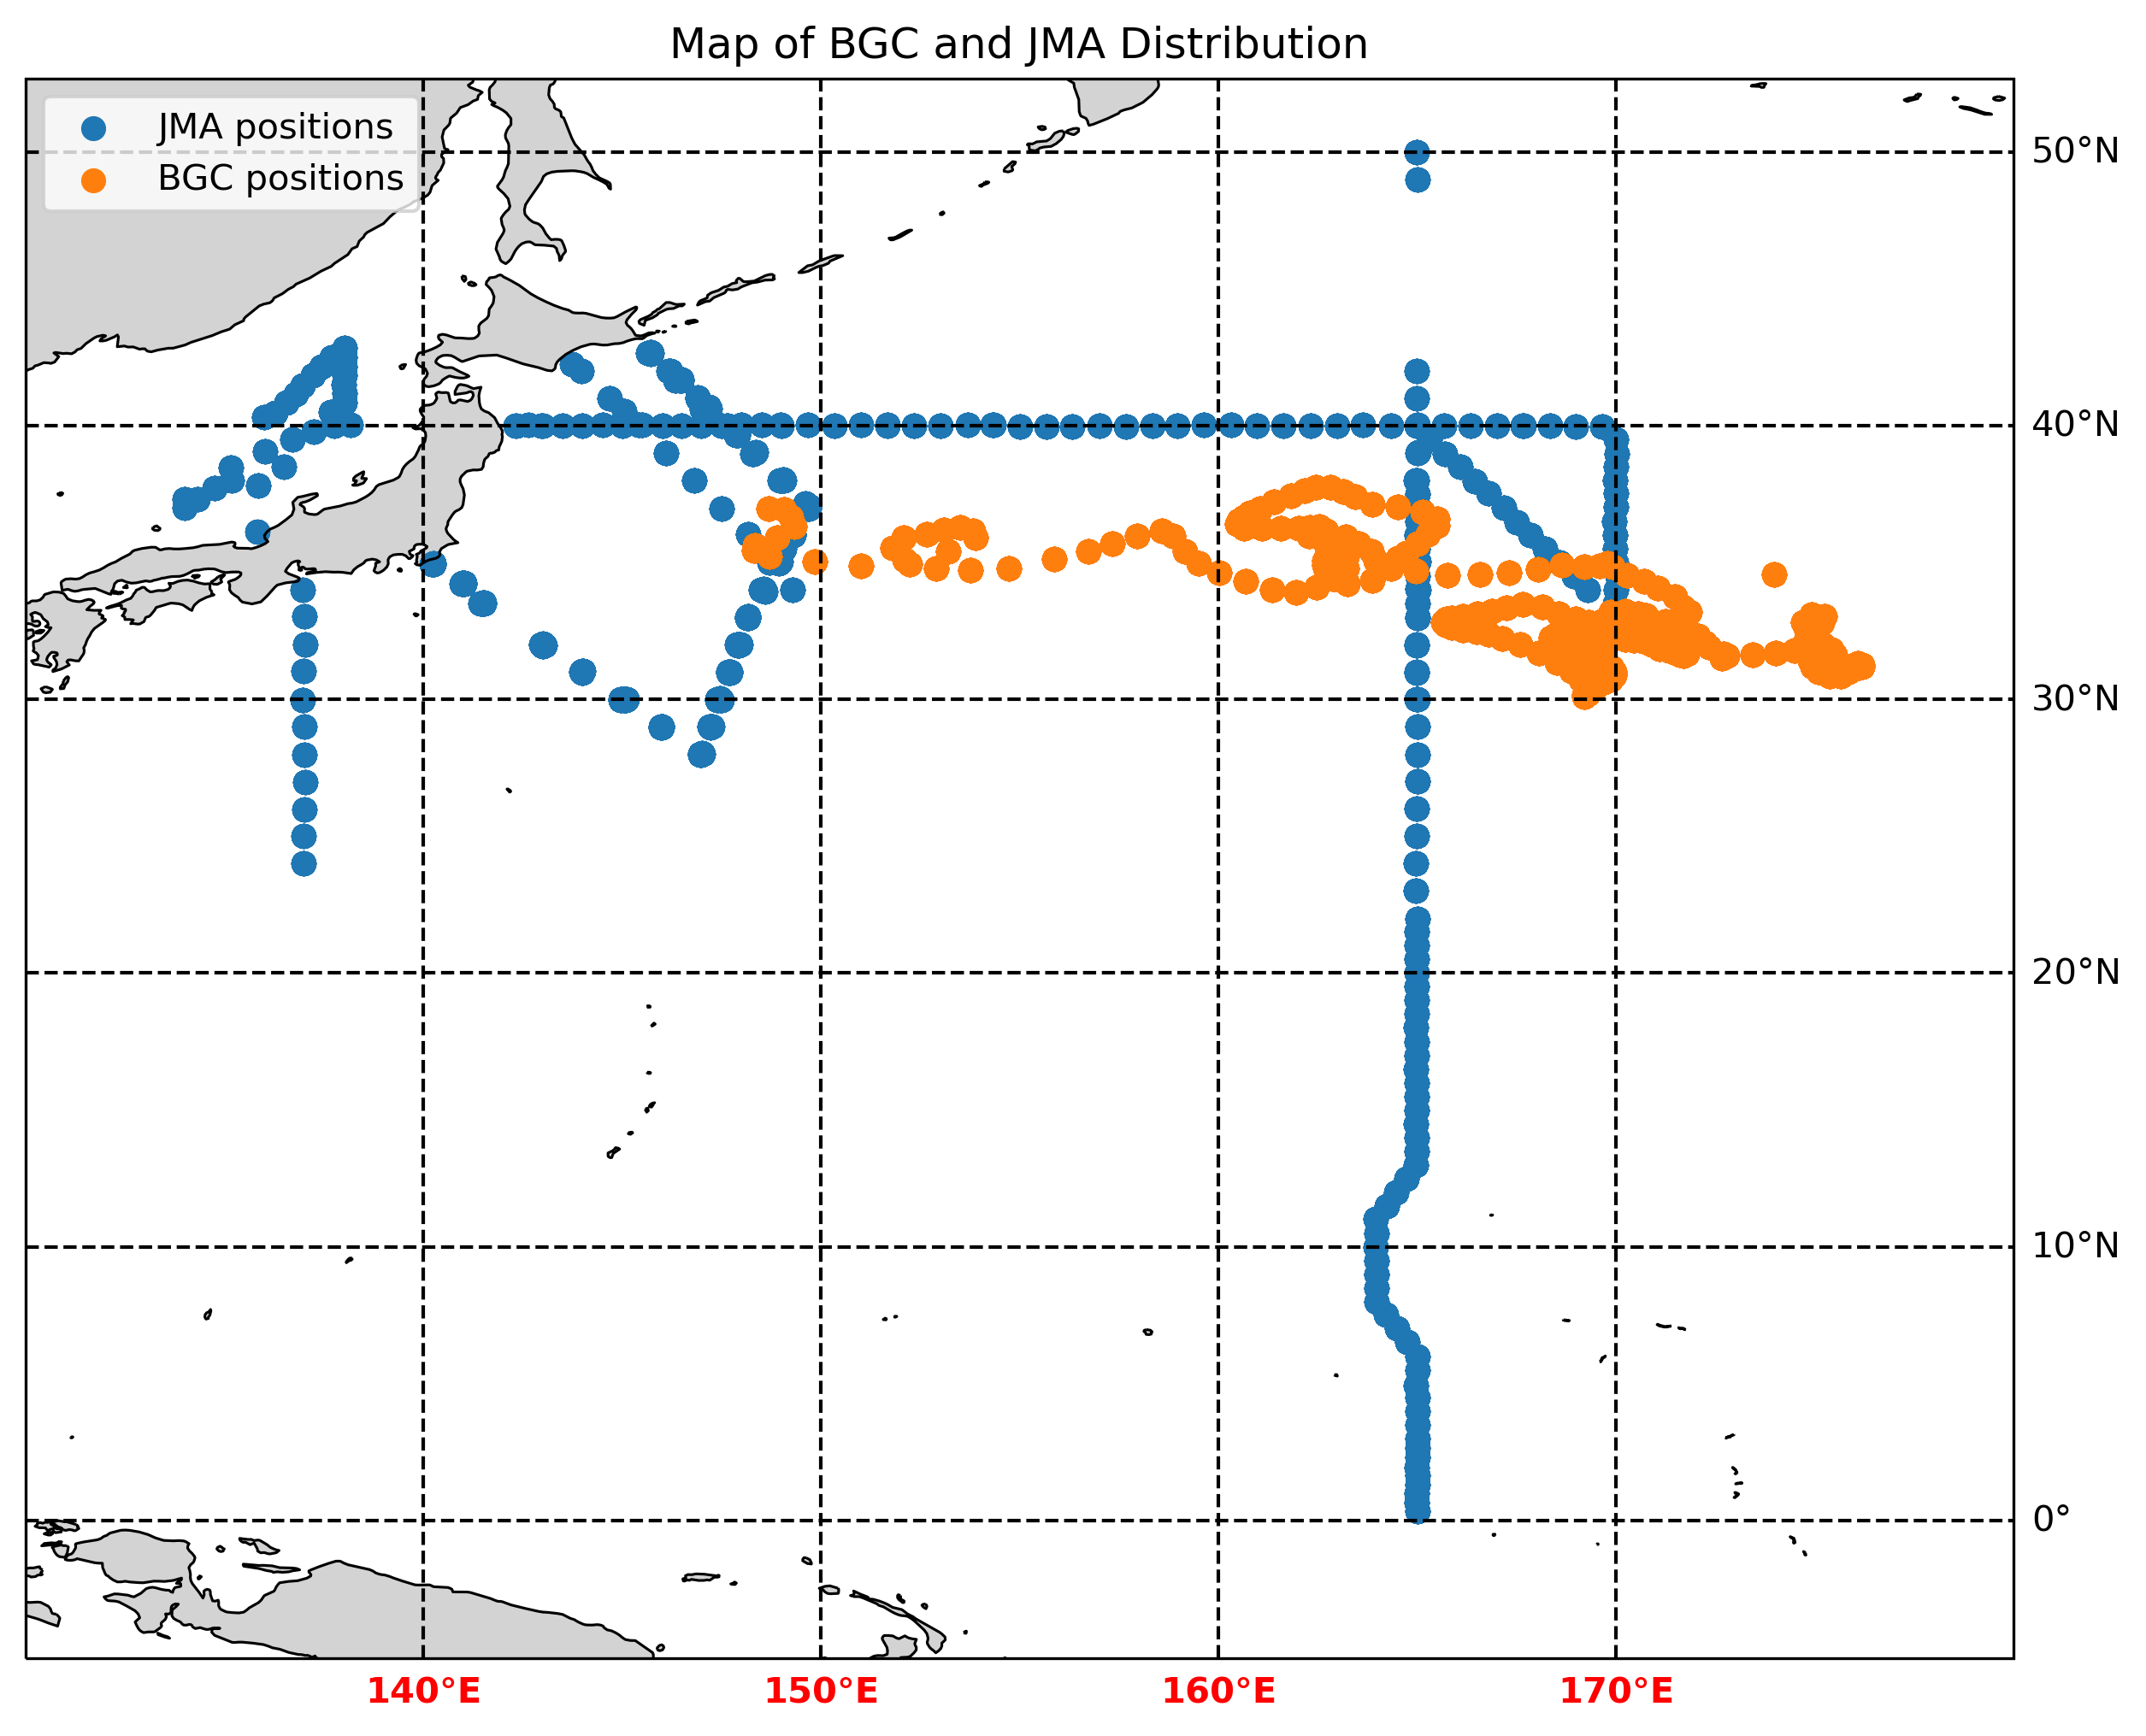

In [ ]:
# Create a regional map with parallels and meridians

fig = plt.figure(figsize = (10,8), dpi = 300)
ax = fig.add_subplot(1,1,1, projection = ccrs.PlateCarree(), aspect = "auto", adjustable = "box")

# ax.set_extent(east, west, south, north)
ax.set_extent([130.0, 180.0, -5, 50.0])

# Being picky with our coastlines
ax.coastlines(linewidth=0.75, color='black')

# Map title
ax.set_title('Map of BGC and JMA Distribution')#, color = 'red', weight = 'bold')
# how to add lines of latitude and longitude
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

line1=ax.scatter(jmadata['lon'],jmadata['lat'], c= '#1f77b4')
line2=ax.scatter(bgcdata['LON'],bgcdata['LAT'], c= '#ff7f0e')
ax.legend([line1, line2], ['JMA positions', 'BGC positions'],loc=2, prop={'size': 10})

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k',linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

ax.add_feature(cp.feature.LAND, facecolor = 'lightgrey')


From this plot, it looks as though the argo float is much more subject to ocean circulation than the JMA cruise data. This would suggest that the bgc argo data is going to be more specific to one water mass rather than several different water masses. The JMA data shows very obvious cruise lines, and also gets much closer to coastal regions, which could influence environmental conditions and nitrate levels. There is some small direct overlap in terms of locations, which could result in a better fitting model.

Text(0.5, 1.0, 'BGC T-S Diagram')

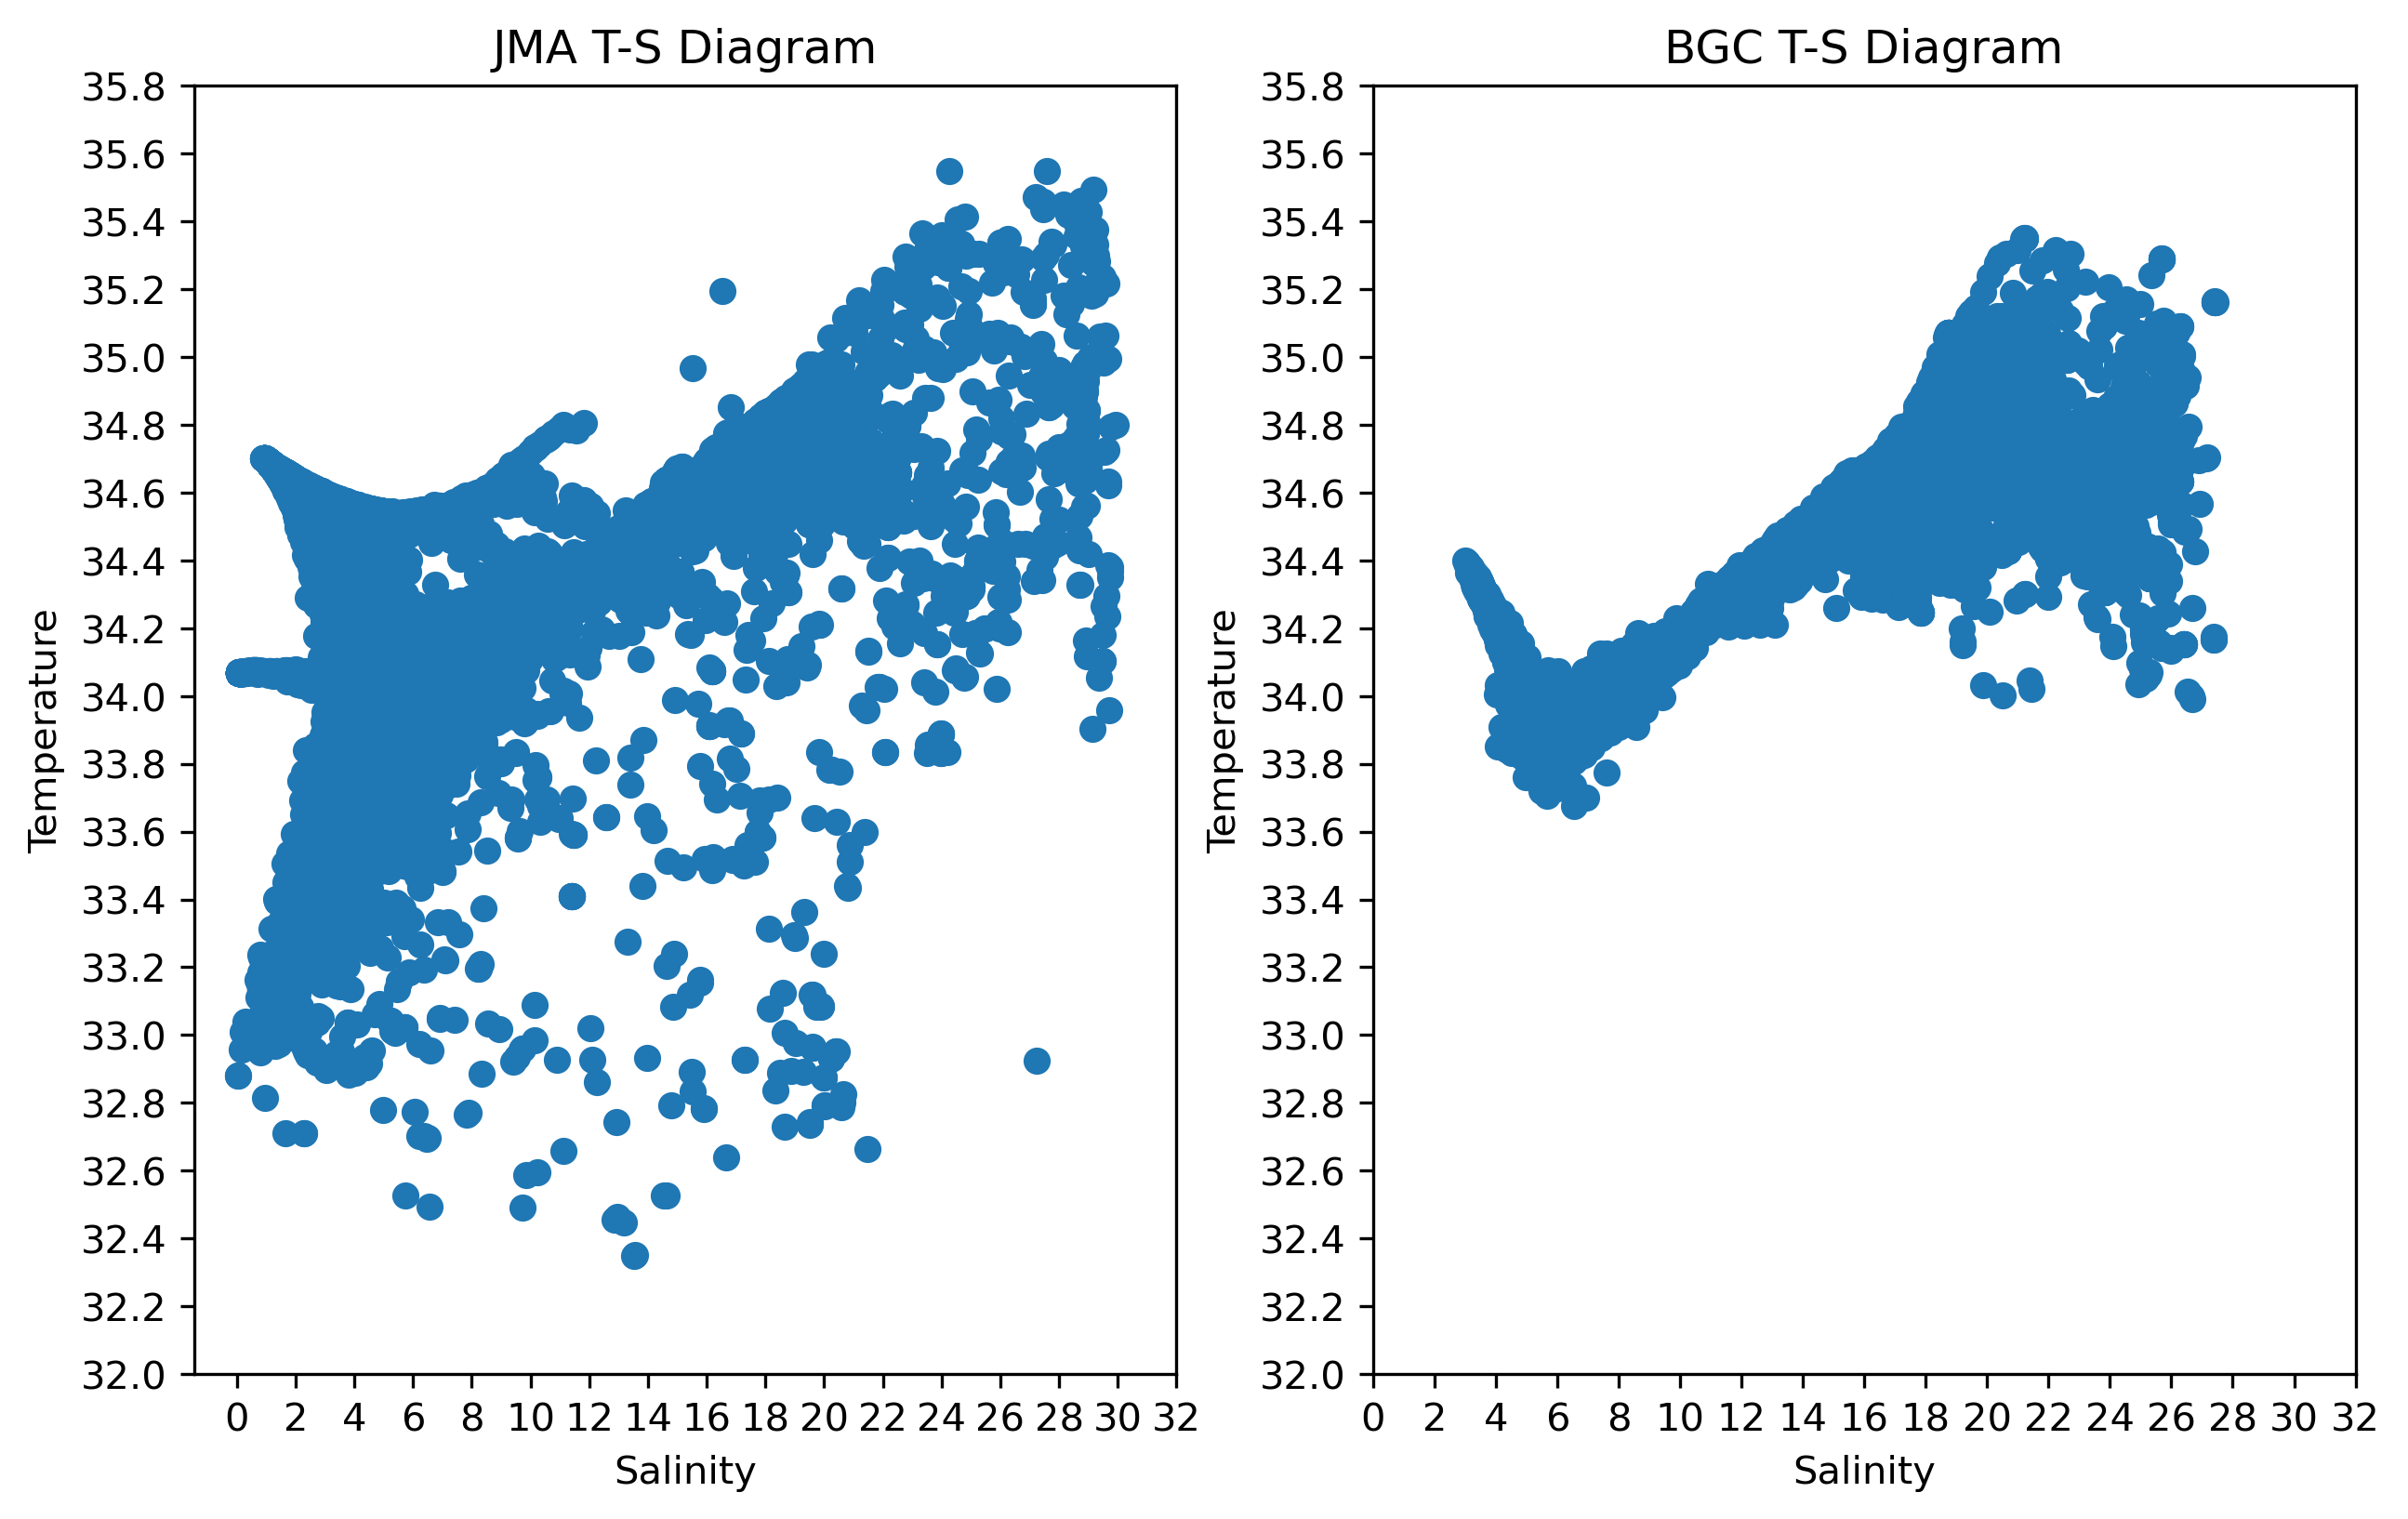

In [ ]:
fig, [ax1,ax2] = plt.subplots(1,2, figsize= (10,6), dpi = 300)
# c1=ax1.scatter(jmadata['theta'],jmadata['sal'],30, jmadata['nitrate'])
# c2=ax2.scatter(bgcno3data['TEMPERATURE[C]'],bgcno3data['SALINITY[PSS]'],30, bgcno3data['NITRATE[uMOL/KG]'])

c1=ax1.scatter(jmadata['theta'],jmadata['sal'])
c2=ax2.scatter(bgcno3data['TEMPERATURE[C]'],bgcno3data['SALINITY[PSS]'])


ax1.set_xlabel('Salinity')
ax1.set_ylabel('Temperature')

ax2.set_xlabel('Salinity')
ax2.set_ylabel('Temperature')

ax1.set_xticks(np.arange(0, 33, 2))
ax2.set_xticks(np.arange(0, 33, 2))

ax1.set_yticks(np.arange(32, 36, 0.2))
ax2.set_yticks(np.arange(32, 36, 0.2))

ax1.set_title("JMA T-S Diagram")
ax2.set_title("BGC T-S Diagram")


These T-S diagrams validate the thoughts above that BGC argo is going to more water mass specific because it is subject to ocean circulation. The JMA data crosses into several different basins, where the BGC argo looks to be in the area of the Kuroisho extension and all properties should be dominated by properties there, including its aspects in regards to what drives nitrate concentrations, while JMA data could have a different array of drivers of nitrate concentration patterns from an array of of water masses. 

## Model application and evaluation ##

We spilt the data into a training and testing set, using the a 80/20 spilt. Then we scaled the predictors, so the range of each parameter is the same. 

Using the training set, we trained, tested, and optimized a nitrate model on the JMA dataset. We use density, depth, and salinity as our predictor variables to target nitrate. We do this using a supervised (target-known) K-NN Regressor model. That uses K number of nearest-neighbor observations to regress target variables as a function of predictors. Following ML-methodology, the model was tested with the remaining testing set of the JMA data. To optimizie, we looped this method with a ranging of K parameters, using the the Rsq and RMSE to assess best K number of nearest neighbors to be regressed. 

Once, the model is trained, tested, and optimized with the JMA data. We further evaluate our model using the BGC Argo data and report the rsq and RMSE to consider how well our model works in a complementary system, that as reasonably similar geographic and depth distributions.

In [ ]:
# Make the data split
y = jmadata.nitrate
X = jmadata[['density','depth','sal']]

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=4)
# test size is the percentage of test points you want, random state is the "seed" number so people can reproduce what you have done

We decided to use density, depth, and salinity for our x variables. Including all three predictors produced a better model than just using one predictor, and other shared variables (location and time) produced a far too complicated and overfit model.

In [ ]:
# just to look and check them
len(X_test)

3115

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
standardized_X = scaler.transform(X_train)
standardized_X_test = scaler.transform(X_test)

We scaled our data using standard scaler, since all the data is on different scales (different ranges of numbers.)

In [ ]:
# initial model build template. 
from sklearn.neighbors import KNeighborsRegressor

# # pick model
# n  = int(input('Choose a number for k: '))

# model = KNeighborsRegressor(n_neighbors=n)
# model.fit(standardized_X, y_train)

# # compute the R^2 score
# print("R^2 score: {0:.2f}".format(model.score(standardized_X, y_train)))

# # plot the model together with the data
# y_pred = model.predict(standardized_X_test)

# #plt.scatter(standardized_X, y_train)
# #plt.plot(standardized_X_test,y_pred)
# #plt.show()

from sklearn.metrics import mean_squared_error, r2_score

# print('r2 =', r2_score(y_train, model.predict(standardized_X)))
# print('r2 =', r2_score(y_test, y_pred))
# print('RMSE =',np.sqrt(mean_squared_error(y_test, y_pred)))
# # we want to minimize RMSE with our model (its how good our model is)

We used this input k code to try a couple different models and get a feel for what values of k were realistic. 1000 was an unrealistic (very poor) model, but below 100 - specifically below 50 showed to have some of the best results. Therefore to keep computational efficiency we kept our loop between k = [1:50]. 

In [ ]:
# For loop to find the best model k
k = []
r2_train = []
r2_test = []
RMSE = []

loops = range(1,51)

for n in loops:
    model = KNeighborsRegressor(n_neighbors=n)
    model.fit(standardized_X, y_train)

    # Use the model to predict y (nitrate values)
    y_pred = model.predict(standardized_X_test)
    
    # Form our lists to plot
    k.append(n)
    r2_train.append(r2_score(y_train, model.predict(standardized_X)))
    r2_test.append(r2_score(y_test, y_pred))
    RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))

Text(0.5, 1.0, 'R2 for Different K Values')

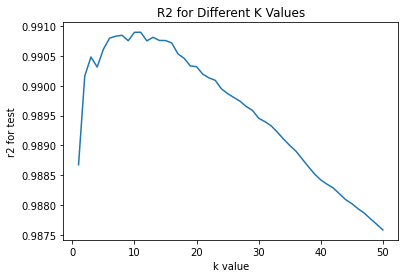

In [ ]:
plt.plot(k,r2_test)
plt.xlabel('k value')
plt.ylabel('r2 for test')
plt.title('R2 for Different K Values')

Text(0.5, 1.0, 'RMSE for Different K Values')

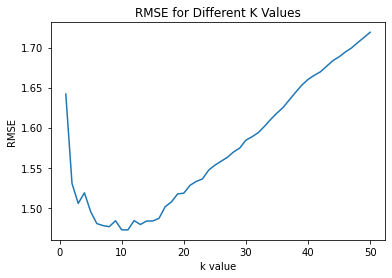

In [ ]:
plt.plot(k,RMSE)
plt.xlabel('k value')
plt.ylabel('RMSE')
plt.title('RMSE for Different K Values')

The plots above are a visual analysis from running the loop with values of the K parameters from 1 to 50 to find the optimal number of nearest-neighbors to regress the testing set target variable, JMA nitrate, and the predicted nitrate value from the testing set predictors. This analysis is done by using the R-Squared and RMSE as metrics to evaluate the model performance. The optimal K is found to be ~5-15, peaking at 10. 

The Rsq and RMSE show that the model only minimally degrades as more nearest neighbors are included. The Rsq and RMSE performance linearly decreases beyond 25, showing that the range between 5-15 optimal to be used with the BGC argo data. We use k=15 to minimize potential for over fitting in this optimal range. 

In [ ]:
# Run the model at k = 15
model15 = KNeighborsRegressor(n_neighbors = 15)
model15.fit(standardized_X, y_train)

# compute the R^2 score
print("R^2 score: {0:.2f}".format(model.score(standardized_X, y_train)))

# plot the model together with the data
y_pred_15 = model15.predict(standardized_X_test)

#plt.scatter(standardized_X, y_train)
#plt.plot(standardized_X_test,y_pred)
#plt.show()

from sklearn.metrics import mean_squared_error, r2_score


print('r2 =', r2_score(y_train, model15.predict(standardized_X)))
print('r2 =', r2_score(y_test, y_pred_15))
print('RMSE =',np.sqrt(mean_squared_error(y_test, y_pred_15)))
# we want to minimize RMSE with our model (its how good our model is)

R^2 score: 0.99
r2 = 0.992036186703088
r2 = 0.9907569168125224
RMSE = 1.4834100770211223


Although it's not the highest of the potential r^2 values, 0.9907 (or the r^2 for the prediction based on the test) is still a very good model for predicting NO3 from density, depth, and salinity. A RMSE of 1.48 is on the very low side, also suggesting that the model error is small relative to predicted and actual NO3 values. 

In [ ]:
# Need to pull out each X variable for plotting
density_test = X_test[['density']]
depth_test = X_test[['depth']]
sal_test = X_test[['sal']]

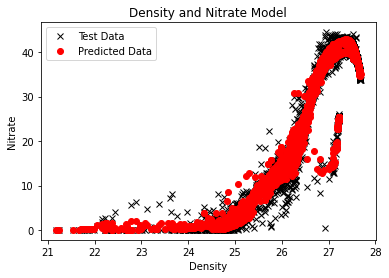

In [ ]:
# Plot to check for overfitting (will follow the outliers exactly)
plt.plot(density_test, y_test, 'xk', label = "Test Data")
plt.plot(density_test, y_pred_15, 'ro', label = "Predicted Data")
plt.xlabel('Density')
plt.ylabel('Nitrate')
plt.title('Density and Nitrate Model')
plt.legend()

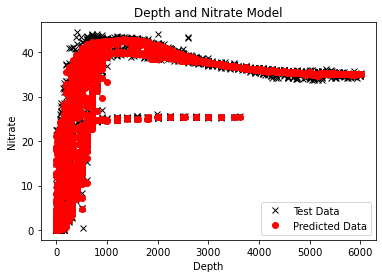

In [ ]:
plt.plot(depth_test, y_test, 'xk', label = "Test Data")
plt.plot(depth_test, y_pred_15, 'ro', label = "Predicted Data")
plt.xlabel('Depth')
plt.ylabel('Nitrate')
plt.title('Depth and Nitrate Model')
plt.legend()

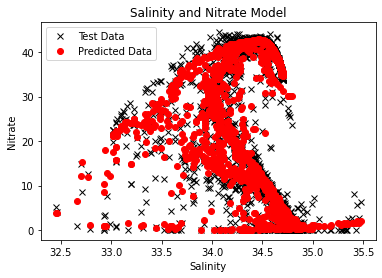

In [ ]:
plt.plot(sal_test, y_test, 'xk', label = "Test Data")
plt.plot(sal_test, y_pred_15, 'ro', label = "Predicted Data")
plt.xlabel('Salinity')
plt.ylabel('Nitrate')
plt.title('Salinity and Nitrate Model')
plt.legend()

The fits are very good. Of note: the testing target set had slightly (very slight) different variablity than the model predictions. This can be seen visually in slightly larger surface areas of the test data versus the predictive data. This complements the slight reduction in r^2 from the training set to the testing set which does quantify a different thing, however the point being if the training set doesn't quite capture the same amount of variablity in the testing set than the r^2 will be reduced. This is expected, it would be weird if spilt data had exactly the same variablity. Increase "surface area" of the data actually could be the ideal case for visual analysis; it could have decreased or stayed the same and still reduced the r^2. The concept of surface area is used loosely here; if this was publication quality work, a reviewer likely would ask me to quantify that visual remark. 

These plots do show that there is not too much overfitting – where the predicted numbers would follow exactly all of the variability in the test data. Thus, we can move forward with using our model on the BGC data.

In [ ]:
# Make the depth range match that of the JMA data (positive numbers)
bgcno3data['DEPTH[M]'] = bgcno3data['DEPTH[M]']*-1

In [ ]:
# Test the model with the BGC Argo data
# bgcdata- need to use the bgcno3 dataset because we removed negative nitrate values earlier, and so they datasets no longer match up
X_bgc = bgcno3data[['SIGMATHETA[KG/M3]','DEPTH[M]','SALINITY[PSS]']]

# scaler = StandardScaler().fit(X_bgc)
stand_X_bgc = scaler.transform(X_bgc)

# plot the model together with the data
bgc_y_pred = model15.predict(stand_X_bgc)

#plt.scatter(standardized_X, y_train)
#plt.plot(standardized_X_test,y_pred)
#plt.show()

y_bgc = bgcno3data[['NITRATE[uMOL/KG]']]


print('r2 =', r2_score(y_bgc, bgc_y_pred))
print('RMSE =',np.sqrt(mean_squared_error(y_bgc, bgc_y_pred)))
# we want to minimize RMSE with our model (its how good our model is)

r2 = 0.9523667663390072
RMSE = 2.8730859764868515


The Rsq show that ~95% of variablity in the target BGC argo nitrate observations was explained by the model predictions and the RMSE of each of those predictions was on the scale of 2.88 when the dynamic range of the the target and predictions was on scale of 0-40. Overall, this means the model resolved the general and finer scale trends of the BGC argo nitrate data.

In [ ]:
# Need to pull out each standardized X variable for plotting
bgc_density = bgcno3data['SIGMATHETA[KG/M3]']
bgc_depth = bgcno3data['DEPTH[M]']
bgc_sal = bgcno3data['SALINITY[PSS]']

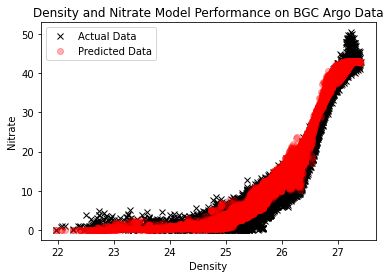

In [ ]:
# Plot to check for overfitting (will follow the outliers exactly)
plt.plot(bgc_density, y_bgc, 'xk', label = "Actual Data")
plt.plot(bgc_density, bgc_y_pred, 'ro', alpha = 0.3, label = "Predicted Data")
plt.xlabel('Density')
plt.ylabel('Nitrate')
plt.title('Density and Nitrate Model Performance on BGC Argo Data')
plt.legend()

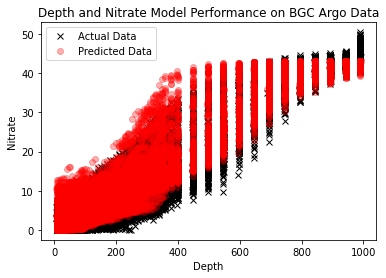

In [ ]:
plt.plot(bgc_depth, y_bgc, 'xk', label = "Actual Data")
plt.plot(bgc_depth, bgc_y_pred, 'ro', alpha = 0.3, label = "Predicted Data")
plt.xlabel('Depth')
plt.ylabel('Nitrate')
plt.title('Depth and Nitrate Model Performance on BGC Argo Data')
plt.legend()

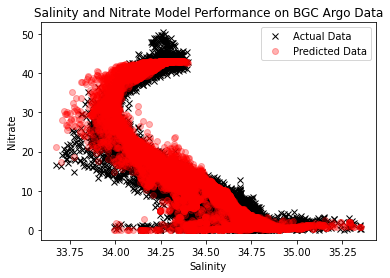

In [ ]:
plt.plot(bgc_sal, y_bgc, 'xk', label = "Actual Data")
plt.plot(bgc_sal, bgc_y_pred, 'ro', alpha = 0.3, label = "Predicted Data")
plt.xlabel('Salinity')
plt.ylabel('Nitrate')
plt.title('Salinity and Nitrate Model Performance on BGC Argo Data')
plt.legend()

The fits are beautiful to the BGC argo data. The model did not do a great job predicting nitrate data above around 40, which could be due to the JMA dataset not having any nitrate values very much above 40, whereas the BGC dataset has nitrates of close to 50. Otherwise, the predictions do very well. 

The reduction of the r^2 is expected when applying the model to the new dataset. That stated it really didn't change much at all, it lost ~4% of variablity explained by model. Potentially, biological drivers play that small a role or nirtate scales are primarliy driven strongly by depth and density so much that surface layer biological patchiness doesn't generate large errors. We have no uptake rates with this data so it is possible uptake could be on the scale of the RMSE. Either way the model works pretty well. The model did a really impressive job to develop regressions between water mass properties and nitrate in a very large area in region with strong ocean circulation drivers. This model may not work for other areas in other oceans, experiencing different conditions, or may not be able to be applied to data from very different time periods. 